In [0]:
!pip install wfdb

     |████████████████████████████████| 102kB 3.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/bb/a9/00/0078d26b0c15b31be0001af8eb659496709c361c69641303f1
Successfully built wfdb


In [0]:
from google.colab import drive
drive.mount('/content/google-drive')
drive_path = '/content/google-drive/My Drive/Colab Notebooks/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/google-drive


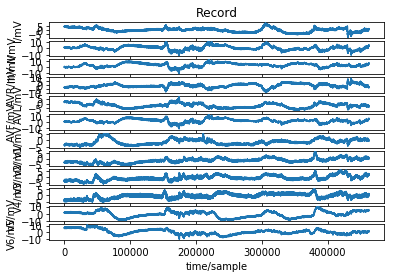

{'adc_gain': [306.0,
  306.0,
  306.0,
  306.0,
  306.0,
  306.0,
  306.0,
  306.0,
  306.0,
  306.0,
  306.0,
  306.0],
 'adc_res': [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16],
 'adc_zero': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'base_counter': None,
 'base_date': None,
 'base_time': None,
 'baseline': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'block_size': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'byte_offset': [None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None],
 'checksum': [-11409,
  21378,
  24619,
  302,
  2125,
  2450,
  -4606,
  30327,
  -27569,
  -13507,
  -4741,
  -28645],
 'comments': ['<age>: 65 <sex>: F <diagnoses> Coronary artery disease, arterial hypertension',
  'patient 1',
  'PVCs, noise'],
 'counter_freq': None,
 'd_signal': None,
 'e_d_signal': None,
 'e_p_signal': None,
 'file_name': ['I01.dat',
  'I01.dat',
  'I01.dat',
  'I01.dat',
  'I01.dat',
  'I01.dat',
  'I01.dat',
  'I01.dat',
  'I01.dat',
  'I01.dat',
  'I01.dat'

In [4]:
import wfdb

# Demo - Read a wfdb record using the 'rdrecord' function into a wfdb.Record object.
# Plot the signals, and show the data.
record = wfdb.rdrecord(drive_path + 'I01') 
wfdb.plot_wfdb(record=record, title='Record') 
display(record.__dict__)

In [0]:
# Demo - Read just a header
header = wfdb.rdheader(drive_path + 'I01')
display(header.__dict__)

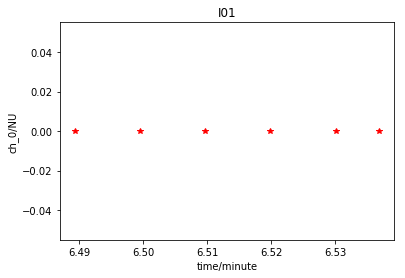

In [0]:
# Demo - Read part of a WFDB annotation file into a wfdb.Annotation object, and plot the samples
annotation = wfdb.rdann(drive_path + 'I01', 'atr', sampfrom=100000, sampto=101000)
annotation.fs = 257
wfdb.plot_wfdb(annotation=annotation, time_units='minutes')


In [0]:
signals, fields = wfdb.rdsamp(drive_path + 'I01', channels=[0, 1, 2, 3], sampfrom=100, sampto=15000)
display(signals)
display(fields)

array([[ 3.71895425,  1.41176471, -0.31045752, -2.69934641],
       [ 3.67647059,  1.42810458, -0.25163399, -2.68627451],
       [ 3.67973856,  1.41503268, -0.26797386, -2.68300654],
       ...,
       [ 2.91830065,  0.5620915 , -0.35947712, -1.87581699],
       [ 2.90196078,  0.53267974, -0.37254902, -1.85294118],
       [ 2.89215686,  0.51960784, -0.37581699, -1.83986928]])

{'base_date': None,
 'base_time': None,
 'comments': ['<age>: 65 <sex>: F <diagnoses> Coronary artery disease, arterial hypertension',
  'patient 1',
  'PVCs, noise'],
 'fs': 257,
 'n_sig': 4,
 'sig_len': 14900,
 'sig_name': ['I', 'II', 'III', 'AVR'],
 'units': ['mV', 'mV', 'mV', 'mV']}

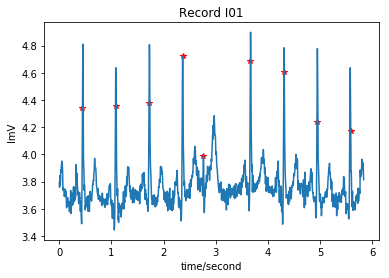

In [0]:
# Demo 5 - Read a WFDB record and annotation. Plot all channels, and the annotation on top of channel 0.
record = wfdb.rdrecord(drive_path + 'I01', channels=[0], sampto = 1500)
annotation = wfdb.rdann(drive_path + 'I01', 'atr', sampto = 1500)

wfdb.plot_wfdb(record=record, annotation=annotation,
               title='Record I01, channel 0',
               time_units='seconds')